In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
from sklearn.model_selection import train_test_split
from PIL import Image

In [2]:
#Parameters for DCNs

Ns=600   #Size of the DCNs：600μm*600μm
lam = 0.8465 #wavelength
Dx=5     #Neuron size: 5μm, must be divisible by Ns

VCSEL_size=np.array([3,3],dtype=int)   #Scale of the VCSEL array
num=VCSEL_size[0]*VCSEL_size[1]   #number of the VCSELs

z=np.array([[963, 1, 1], 
            [1020, 1.4526, 1],
            [5000, 1, 0]
           ])


#训练参数
n_epochs = 100
learning_rate = 0.06

In [4]:
x_train = pd.read_csv("Train_edge_denosing.csv",delimiter=',',header=None,engine='c',na_filter=False,dtype=np.float32,low_memory=False)
x_train = (x_train.iloc[:,:].values).astype('float32') # all pixel values
m=x_train.shape[0]

print(m)

100


In [5]:
#Generating the input light field for each VCSEL unit

#Read the calculated amplitude distribution of LP01 mode
amplitude = pd.read_csv("amplitude _Gaussian.csv",delimiter=',',header=None,engine='c',na_filter=False,dtype=np.float32,low_memory=False)

amplitude1=amplitude/255

VCSEL = np.zeros((num,Ns,Ns),dtype=float)

i=0
Na=int(Ns/2-50*VCSEL_size[0]+50) #起始坐标x
Nb=int(Ns/2-50*VCSEL_size[1]+50) #起始坐标y

for a in range(VCSEL_size[0]): 
    for b in range(VCSEL_size[1]):
        x1=Na+100*(a)-4
        x2=Na+100*(a)+6
        y1=Nb+100*(b)-4
        y2=Nb+100*(b)+6
        VCSEL[i,x1:x2,y1:y2]=amplitude1
        i=i+1

In [6]:
#Tensorflow training: Angular Diffraction
def Propogation(E,Ns,λ,z1,n):  #light field, Size, wavelength, propagation distance, refrective index
    
    Nx = Ns             
    dx = 1            
    lam =λ/n          
    z = z1              
#    T_Field = {}
    fx = np.fft.fftshift(np.fft.fftfreq(Nx, d = dx))
    fxx, fyy = np.meshgrid(fx, fx)
    argument = (2 * np.pi)**2 * ((1. / lam) ** 2 - fxx ** 2 - fyy ** 2)

    #Calculate the propagating and the evanescent (complex) modes
    tmp = np.sqrt(np.abs(argument))
    kz = np.where(argument >= 0, tmp, 1j*tmp)
    # compute angular spectrum

    fft_c = tf.signal.fft2d(E)
    c = tf.signal.fftshift(fft_c)
        # propagate the angular spectrum a distance z
    Field = tf.signal.ifft2d(tf.signal.ifftshift(c * np.exp(1j * kz * z)))
    
    return Field

#Tensorflow training: Amplitude superposition of the light fields of the VCSELs
def Total_Amp_Field(E):
    E=tf.reduce_sum(tf.abs(E),axis=0)
    return E

In [7]:
#numpy: Angular Diffraction
def Propogation_1(E,Ns,λ,z1,n):  #light field, Size, wavelength, propagation distance, refrective index
    
    Nx = Ns             
    dx = 1            
    lam =λ/n          
    z = z1             
#    T_Field = {}
    fx = np.fft.fftshift(np.fft.fftfreq(Nx, d = dx))
    fxx, fyy = np.meshgrid(fx, fx)
    argument = (2 * np.pi)**2 * ((1. / lam) ** 2 - fxx ** 2 - fyy ** 2)

    #Calculate the propagating and the evanescent (complex) modes
    tmp = np.sqrt(np.abs(argument))
    kz = np.where(argument >= 0, tmp, 1j*tmp)
    kz = np.exp(1j * kz * z)

    fft_c = np.fft.fft2(E)
    c = np.fft.fftshift(fft_c)

    # propagate the angular spectrum a distance z
    return np.fft.ifft2(np.fft.ifftshift(c * kz))

#numpy: : Amplitude superposition of the light fields of the VCSELs
def Total_Amp_Field1(E):
    E=np.abs(E)
    return np.sum(E,axis=0)

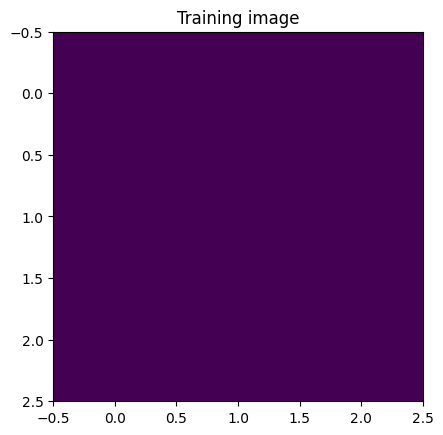

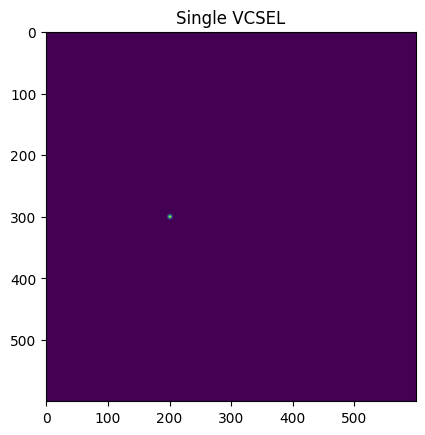

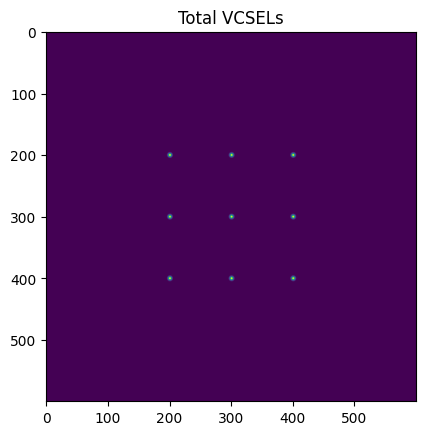

In [9]:
#验证训练集
t=10

plt.figure()
plt.imshow(x_train[t].reshape(VCSEL_size))
plt.title('Training image')
plt.show()

# 验证单个VCSEL
plt.figure()
plt.imshow(np.abs(VCSEL[3]))
plt.title('Single VCSEL')
plt.show()

# 验证全部VCSEL
V=Total_Amp_Field1(VCSEL)
plt.figure()
plt.imshow(V)
plt.title('Total VCSELs')
plt.show()

In [10]:
#Calculate the light field of on first diffractive layer
VCSEL_after_diffraction = Propogation_1(VCSEL,Ns,lam,z[0,0],z[0,1])

(9, 600, 600)


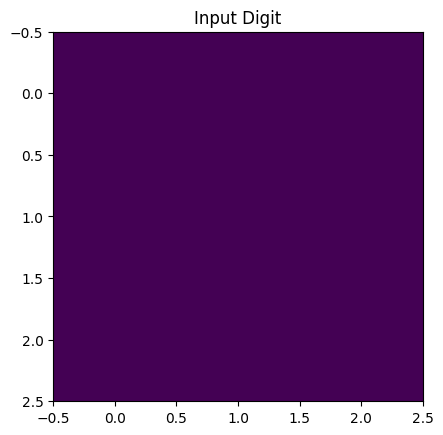

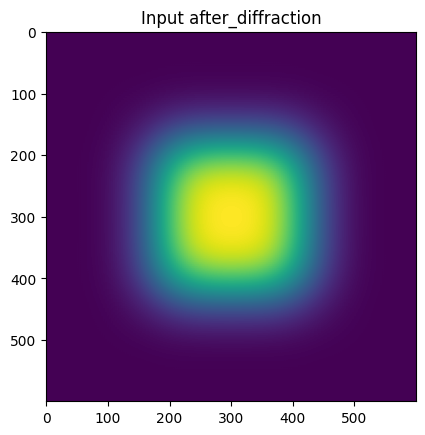

In [11]:
print(VCSEL_after_diffraction.shape)
test_input = x_train[1]
plt.imshow(test_input.reshape(VCSEL_size))
plt.title('Input Digit')
plt.show()
#test_output = []

test_output = np.zeros((num,Ns,Ns),dtype=complex)
for i in range(0,num):
    test_output[i,:,:]=test_input[i]*VCSEL_after_diffraction[i,:,:]

test_output1 = Total_Amp_Field1(test_output)
#test_output1 = np.sum(test_output,axis=0)
plt.imshow(np.abs(test_output1**2))
plt.title('Input after_diffraction')
plt.show()

1.0
(9, 600, 600)
(1, 600, 600)


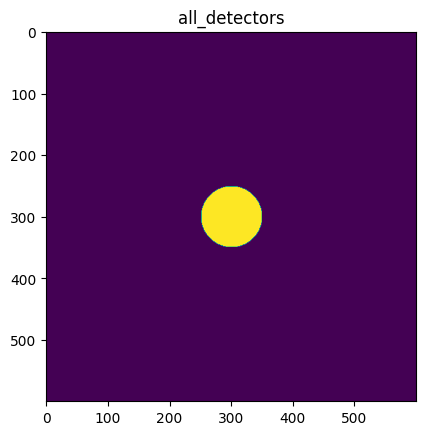

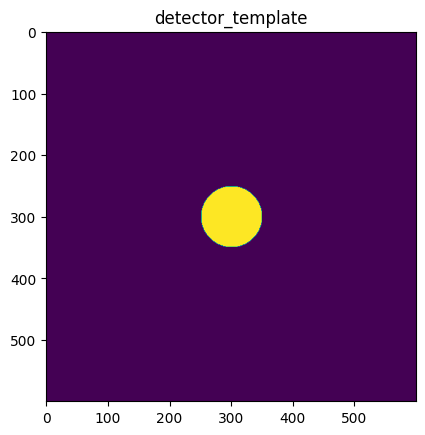

In [21]:
#detection region
r=50
area=np.zeros([2*r,2*r])
for x in range(2*r):
    for y in range(2*r):
        if ((x-r+0.5)**2+(y-r+0.5)**2)<=(r-0.5)**2:
                    area[x,y]=1.0
area=area/np.max(area)


#area=np.ones([40,40],dtype=float)
b=np.zeros([9,Ns,Ns],dtype=float)


b[8,(301-r):(301+r),(301-r):(301+r)]=area*0.5
b[7,(301-r):(301+r),(301-r):(301+r)]=area*0.707
b[6,(301-r):(301+r),(301-r):(301+r)]=area*0.5
b[5,(301-r):(301+r),(301-r):(301+r)]=area*0.707
b[4,(301-r):(301+r),(301-r):(301+r)]=area*1
b[3,(301-r):(301+r),(301-r):(301+r)]=area*0.707
b[2,(301-r):(301+r),(301-r):(301+r)]=area*0.5
b[1,(301-r):(301+r),(301-r):(301+r)]=area*0.707
b[0,(301-r):(301+r),(301-r):(301+r)]=area*0.5



detector_template=b
all_detectors=detector_template[4,:,:]
all_detectors=all_detectors.reshape(1,Ns,Ns)


print(all_detectors[0,300,300])
print(detector_template.shape)
print(all_detectors.shape)

plt.imshow(all_detectors.reshape(Ns,Ns))
plt.title('all_detectors')
plt.show()

plt.imshow(detector_template[0,:,:].reshape(Ns,Ns))
plt.title('detector_template')
plt.show()

#detector_template=np.sum(detector_template,axis=(1,2))
#print(detector_template)

In [ ]:
#统计DNNs的层数
NL=0
for i in range(z.shape[0]):
    if z[i,2]==1:
        NL=NL+1
batch_size = 1 #VCSEL训练模型下，batch_size必须为1

#Training parameters
n_batches = int(np.ceil(m / batch_size))
#tf.reset_default_graph()
tf.compat.v1.reset_default_graph()
# Construct Tensorflow Graph
tf.compat.v1.disable_eager_execution()
inputs = tf.compat.v1.placeholder(tf.complex64, shape=(batch_size, num), name='inputs')  # input test cases
labels = tf.compat.v1.placeholder(tf.int32, shape=(batch_size,), name='labels')  # labels for test cases
d = tf.constant(detector_template, dtype=tf.float32, name='detectors')  # 10 x N**2
all_d = tf.constant(all_detectors, dtype=tf.float32, name='all_detectors')  # 1 x N**2
VCSEL_after_diffraction1 = tf.constant(VCSEL_after_diffraction, dtype=tf.complex64, name='VCSEL_after_diffraction')
# Input layer

def diffraction_layer(X,Dx):
    # Complex amplitude + phase of optical waves
    #a = tf.Variable(tf.constant(1, shape=[1, N, N], dtype=tf.float32), name='alpha')
    t = tf.Variable(tf.compat.v1.random_normal([1,int(Ns/Dx),int(Ns/Dx)], dtype=tf.float32)) 
    #t = tf.Variable(tf.constant(0, shape=[1, int(Ns/Dx), int(Ns/Dx)], dtype=tf.float32), name='theta') 
    t1=tf.repeat(t,Dx,axis=1)
    t2=tf.repeat(t1,Dx,axis=2)
    pi = tf.constant(math.pi, dtype=tf.float32)
    theta = 2 * pi * t2  # phase in exp(j*theta)
    phase_mod = tf.complex(tf.cos(theta), tf.sin(theta), name='phase_mod')
    #phase_mod = tf.math.exp(1j*tf.cast(theta,dtype=tf.complex64))
    #a_mod = tf.nn.relu(a) / tf.reduce_max(tf.nn.relu(a))
    #amp_mod = tf.cast(a_mod, dtype=tf.complex64, name='amp_mod')
    #com_mod = tf.multiply(amp_mod, phase_mod, name='com_mod')
    layer = X * tf.tile(phase_mod, [num, 1 , 1])  # BS x N**2
    return layer


# 衍射层传播过程
#inputs1=tf.transpose(inputs)
inputs1=tf.reshape(inputs,[num,1,1])
Feild=tf.multiply(inputs1, VCSEL_after_diffraction1)


for i in range(z.shape[0]-1):
    if z[i,2]==1:
        Feild = diffraction_layer(Feild,Dx)
    Feild=Propogation(Feild,Ns,lam,z[i+1,0],z[i+1,1])

#outputsf=tf.reshape(Feild, [num,Ns*Ns])
outputsf=tf.abs(Feild)

out_norm = outputsf/tf.reduce_max(outputsf)

out_norm=out_norm*tf.tile(all_d, [num, 1 , 1])

#out_norm=tf.reduce_sum(out_norm,axis=(1,2))

loss=tf.reduce_mean((tf.square(out_norm-d)))



# Cross Entropy
#outputsf=tf.reshape(outputsf, [batch_size,Ns*Ns])
#out = tf.matmul(tf.abs(outputsf), d)  # only sum over detectors

#sm = tf.nn.softmax(logits=out_norm, name='soft_max')
#loss=tf.reduce_mean((tf.square(sm-labels)))
#xent = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=labels, logits=out_norm)
#loss = tf.reduce_mean(xent, name='loss')
# Optimizer
# optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
# optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate,momentum=0.9)


optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)

training_op = optimizer.minimize(loss)

# Mini-Batch Gradient Descent
def fetch_batch(epoch, batch_index, batch_size):
    np.random.seed(epoch * n_batches + batch_index)
    indices = np.random.randint(m, size=batch_size)
    X_batch = x_train[indices,]
    return X_batch

init = tf.compat.v1.global_variables_initializer()
saver = tf.compat.v1.train.Saver()

# Summary
loss_summary = tf.compat.v1.summary.scalar('Loss', loss)
file_writer = tf.compat.v1.summary.FileWriter("tf_logs", tf.compat.v1.get_default_graph())

# Session
with tf.compat.v1.Session() as sess:
    sess.run(init)

    for epoch in range(n_epochs):
        epoch_loss = 0  # reset loss
        #test_softmax = np.empty((m,detector_template.shape[1]))
        
        for batch_index in range(n_batches):
            X_batch = fetch_batch(epoch, batch_index, batch_size)

            if batch_index % 100 == 0:
                summary_str = loss_summary.eval(feed_dict={inputs: X_batch})
                step = epoch * n_batches + batch_index
                file_writer.add_summary(summary_str, step)
            
            batch_loss = sess.run([training_op, loss], feed_dict={inputs: X_batch})
            #print(batch_loss)
            epoch_loss += batch_loss[1]
                    
        print("Epoch：", epoch, "Loss =",
              epoch_loss / n_batches)  # print out loss averaged over all batches
        save_path = saver.save(sess, "tmp/my_model.ckpt")
            
    save_path = saver.save(sess, "tmp/my_model_final.ckpt")

    # Sample Results From Mini-batch
    test_input = X_batch
    test_output = sess.run([out_norm],feed_dict={inputs: X_batch})
    
    c=[]
    # Complex Modulation
    if NL==1:
        c.append(sess.run([tf.compat.v1.get_default_graph().get_tensor_by_name("phase_mod:0")]))
    if NL>1:
        c.append(sess.run([tf.compat.v1.get_default_graph().get_tensor_by_name("phase_mod:0")]))
        for i in range(NL-1):
            c.append(sess.run([tf.compat.v1.get_default_graph().get_tensor_by_name("phase_mod_"+str(i+1)+":0")]))

file_writer.close()

In [ ]:
#显示每层相位板c[i]

c1=np.array(c,dtype=complex)
print(np.min(np.abs(c1[0].reshape(Ns,Ns))))
print(np.max(np.abs(c1[0].reshape(Ns,Ns))))
print(c1.shape)

def amp_phase(c):
    return np.abs(c),np.angle(c)

fig, ax = plt.subplots(NL,2,figsize=((10,4*NL)))

ax=ax.reshape([NL,2])

for ind,c2 in enumerate((c1)):
    A,P = amp_phase(c2)
    im = ax[ind,0].imshow(A.reshape((Ns,Ns)))
    fig.colorbar(im,ax=ax[ind,0])
    im = ax[ind,1].imshow(P.reshape((Ns,Ns)))
    fig.colorbar(im,ax=ax[ind,1])

plt.show()

In [ ]:
#Save the phase distributions of DCNs

def save_a(obj,name):
    obj1=(np.angle(obj)+np.pi)/2/np.pi*255
    obj2=Image.fromarray(np.array(obj1,dtype='uint8'))
    obj2.save(r'C:\Users\DELL\Desktop\{}.bmp'.format(name))
    
for i in range(NL):
    save_a(c1[i].reshape(Ns,Ns), 'phi'+str(i+1))